In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

import h5py as h5

In [2]:
import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
datapath='if-image-train.h5'

from iftool.image_challenge import ParticleImage2D
train_data = ParticleImage2D(data_files=[datapath])


In [4]:
print('Size of dataset',len(train_data))

# Access the 0-th instance
data = train_data[0]

# The data instance is a dictionary
print('List of keys in a data element',data.keys(),'\n')

# Visualize the image
# print('Again 0-th image! PDG code %d ... label %d \n' % (data['pdg'],data['label']))
# plt.imshow(data['data'],origin='lower')
# plt.show()
data['label']

Size of dataset 400000
List of keys in a data element dict_keys(['data', 'label', 'pdg', 'index']) 



1

In [5]:
train_data = ParticleImage2D(data_files = [datapath],
                             start = 0.0, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 0.9, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )
validation_data = ParticleImage2D(data_files = [datapath],
                             start = 0.9, # start of the dataset fraction to use. 0.0 = use from 1st entry
                             end   = 1.0, # end of the dataset fraction to use. 1.0 = use up the last entry
                            )

# We use a specifically designed "collate" function to create a batch data
from iftool.image_challenge import collate
from torch.utils.data import DataLoader,random_split
train_loader = DataLoader(train_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 2,
                          batch_size  = 64
                         )

validation_loader = DataLoader(  validation_data,
                          collate_fn  = collate,
                          shuffle     = True,
                          num_workers = 2,
                          batch_size  = 64
                         )

print(len(train_loader))
print(len(validation_loader))

5625
625


In [6]:
import torch.nn as nn

class CNN(nn.Module):
    # This is a test
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # self.fc1 = nn.Linear(48*48*out_2, out_2*48)
        # self.fc2 = nn.Linear(48*out_2,out_2)
        # self.fc3 = nn.Linear(48*48*out_2,4)
        self.fc1 = nn.Linear(48*48*out_2,4)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = nn.Dropout(p=0.5)(x)
        x = self.fc1(x)
        # x = torch.relu(x)
        # x = self.fc2(x)
        # x = torch.relu(x)
        # x = self.fc3(x)
        x = nn.Softmax(dim=1)(x)
        return x

    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)

        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

In [7]:
# Create the model object using CNN class

model = CNN(out_1=8, out_2=16)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=4, bias=True)
)

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

total parameters: 150884


In [9]:
# Train the model

n_epochs=20
validation_acc_list=[]
validation_loss_list=[]
train_acc_list = []
train_loss_list = []
N_train = len(train_data)
N_test=len(validation_data)
# COST=0


def train_model(n_epochs):
    for epoch in range(n_epochs):
        # COST=0
        train_cost=0
        train_correct = 0
        print ("epoch is {}".format(epoch))
        # train_step = 0
        for row in train_loader:
            optimizer.zero_grad()
            x = row['data']
            y = row['label']
            x = x.to(device)
            y = y.to(device)
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            train_correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            train_cost += loss.data
            # COST+=loss.data
            # train_step += 1
            # print("train step is {}".format(train_step))
            
        train_acc = train_correct/N_train
        train_loss = train_cost/len(train_loader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        validation_correct=0
        validation_cost = 0
        # torch.save(model, 'model.pth')
        #perform a prediction on the validation  data
        for row in validation_loader:
            x_test = row['data']
            y_test = row['label']
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            with torch.no_grad():
                z_test = model(x_test)
            _, y_test_hat = torch.max(z_test.data, 1)
            validation_correct += (y_test_hat == y_test).sum().item()
            loss = criterion(z_test, y_test)
            validation_cost += loss.data
            
        validation_acc = validation_correct / N_test
        validation_loss = validation_cost / len(validation_loader)
        validation_acc_list.append(validation_acc)
        validation_loss_list.append(validation_loss)
        
        print("validation accuracy is {}".format(validation_acc))
        print("validation loss is {}".format(validation_loss))
        print("train accuracy is {}".format(train_acc))
        print("train loss is {}".format(train_loss))


In [10]:
import time
tstart=time.time()
print("start time is {}".format(tstart))


train_model(20)
torch.save(model, 'model_CNN2_LowLR_20.pth')
print("duration is {}".format(time.time()-tstart))

start time is 1692225600.1954293
epoch is 0
validation accuracy is 0.8381
validation loss is 0.9042844772338867
train accuracy is 0.8165055555555556
train loss is 0.9258762001991272
epoch is 1
validation accuracy is 0.844725
validation loss is 0.8975163698196411
train accuracy is 0.8434638888888889
train loss is 0.8992500901222229
epoch is 2
validation accuracy is 0.851825
validation loss is 0.8910478353500366
train accuracy is 0.8507333333333333
train loss is 0.8922442197799683
epoch is 3
validation accuracy is 0.8666
validation loss is 0.8751341700553894
train accuracy is 0.8601222222222222
train loss is 0.8823367953300476
epoch is 4
validation accuracy is 0.87595
validation loss is 0.8667051792144775
train accuracy is 0.874025
train loss is 0.8683630228042603
epoch is 5
validation accuracy is 0.876575
validation loss is 0.8651114106178284
train accuracy is 0.8797972222222222
train loss is 0.8625405430793762
epoch is 6
validation accuracy is 0.883925
validation loss is 0.858234763145

In [11]:
train_loss = np.array([])
# train_acc = np.array([])
validation_loss = np.array([])
# validation_acc = np.array([])

for i in range(len(train_loss_list)):
    train_loss = np.append(train_loss, train_loss_list[i].detach().cpu().numpy())
    # train_acc = np.append(train_acc, train_acc_list[i].detach().cpu().numpy())
    validation_loss = np.append(validation_loss, validation_loss_list[i].detach().cpu().numpy())
    # validation_acc = np.append(validation_acc, validation_acc_list[i].detach().cpu().numpy())
    
train_loss

array([0.9258762 , 0.89925009, 0.89224422, 0.8823368 , 0.86836302,
       0.86254054, 0.85787386, 0.85439634, 0.85227334, 0.8501212 ,
       0.84866548, 0.8465212 , 0.84532225, 0.84365088, 0.84279001,
       0.841295  , 0.84090137, 0.83958101, 0.83876294, 0.83797359])

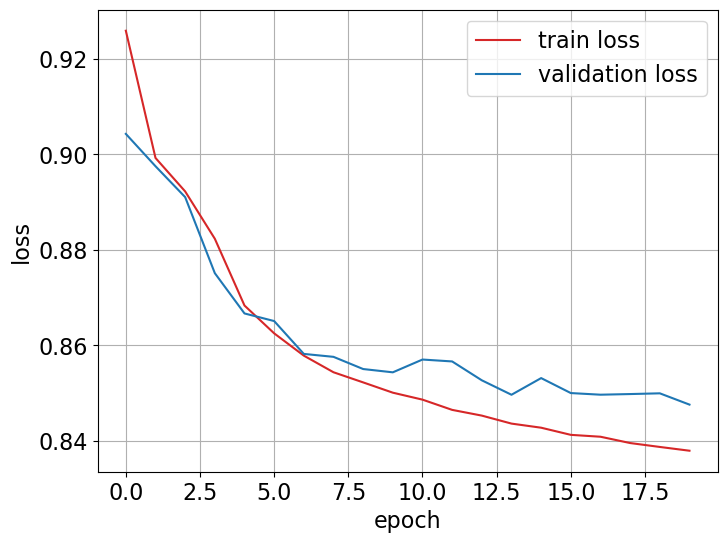

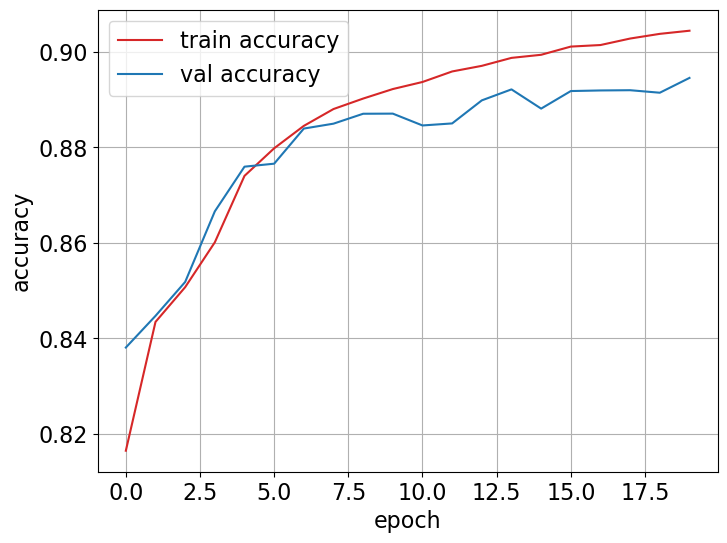

In [12]:
fig1 = plt.figure()
color1 = 'tab:red'
color2 = 'tab:blue'
plt.plot(train_loss, color=color1, label='train loss')
plt.plot(validation_loss,color=color2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
fig1.savefig("CNNResults/CNN2-lowLR-20-loss.png")

fig2 = plt.figure()
color1 = 'tab:red'
color2 = 'tab:blue'
plt.plot(train_acc_list, color=color1, label='train accuracy')
plt.plot(validation_acc_list,color=color2, label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
fig2.savefig("CNNResults/CNN2-lowLR-20-accuracy.png")

In [13]:
from iftool.image_challenge import ParticleImage2D
test_datapath='if-image-test.h5'

test_data = ParticleImage2D(data_files=[test_datapath])
print('Size of test dataset',len(test_data))


# We use a specifically designed "collate" function to create a batch data
from iftool.image_challenge import collate
from torch.utils.data import DataLoader,random_split

test_loader = DataLoader(test_data,
                          collate_fn  = collate,
                          shuffle     = False,
                          num_workers = 2,
                          batch_size  = 64
                         )

N_test2 = len(test_data)
print(len(test_loader))

test_accuracy_list=[]

Size of test dataset 100000
1563


In [14]:
import torch
import torch.nn as nn

def evaluate_model(model_path):

    model_new = torch.load(model_path)
    model_new.to(device)
    model_new.eval()
    
    test_correct=0
    prediction = np.array([])
    true = np.array([])
    i = 0
    for row in test_loader:
        i += 1
        x_test = row['data']
        y_test = row['label']
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        with torch.no_grad():
            z = model_new(x_test)
        _, yhat = torch.max(z.data, 1)
        test_correct += (yhat == y_test).sum().item()
        prediction = np.append(prediction, yhat.detach().cpu().numpy())

        true = np.append(true, y_test.detach().cpu().numpy())
        
        if i%100 == 0:
            print("we are at interation {}".format(i))
 
    test_accuracy = test_correct / N_test2
    test_accuracy_list.append(test_accuracy)
    print("test accuracy is {}".format(test_accuracy))

    return true, prediction, test_accuracy    

In [15]:
true, prediction, test_accuracy = evaluate_model('model_CNN2_LowLR_20.pth')

we are at interation 100
we are at interation 200
we are at interation 300
we are at interation 400
we are at interation 500
we are at interation 600
we are at interation 700
we are at interation 800
we are at interation 900
we are at interation 1000
we are at interation 1100
we are at interation 1200
we are at interation 1300
we are at interation 1400
we are at interation 1500
test accuracy is 0.89381


In [ ]:
print(prediction[0:10])

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [17]:
cm = confusion_matrix(true, prediction, normalize='true')

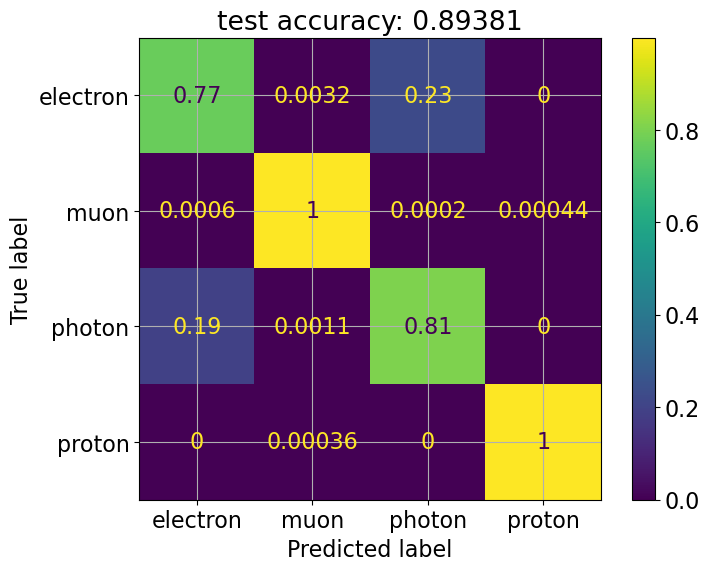

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['electron', 'muon', 'photon', 'proton'])
disp.plot()

disp.ax_.set_title("test accuracy: {}".format(test_accuracy))
plt.show()
disp.figure_.savefig("CNNResults/CNN2-CM-LowLR-20.png")